# Connecting

In [1]:
import openeo

#connect with VITO backend
connection = openeo.connect("https://openeo.vito.be")

In [2]:
connection.authenticate_basic("driesj","driesj123")

<Connection to 'https://openeo.vito.be/openeo/1.0/' with BearerAuth>

In [3]:
from rasterio.io import MemoryFile
def plot_result(data):
    with MemoryFile(geotiff_bytes) as memfile:
        with memfile.open() as dataset:
            data_array = dataset.read()
        from rasterio.plot import show,show_hist
        import matplotlib.pyplot as plt
        fig, (l, r) = plt.subplots(1, 2,figsize=(12, 5))
        
        show(data_array,cmap='YlGn',ax=l)
        show_hist(data_array,ax=r)

## Retrieving results as image

In [4]:
s2_fapar = connection.load_collection("TERRASCOPE_S2_FAPAR_V2",
            spatial_extent={'west':16.138916,'east':16.524124,'south':48.1386,'north':48.320647,'crs':'EPSG:4326'},
            temporal_extent=["2020-05-01","2020-05-20"] )

#specify process graph
fapar_composite = s2_fapar.max_time()
%time geotiff_bytes = fapar_composite.download(format="GTiff")

CPU times: user 72.9 ms, sys: 67.5 ms, total: 140 ms
Wall time: 34.1 s


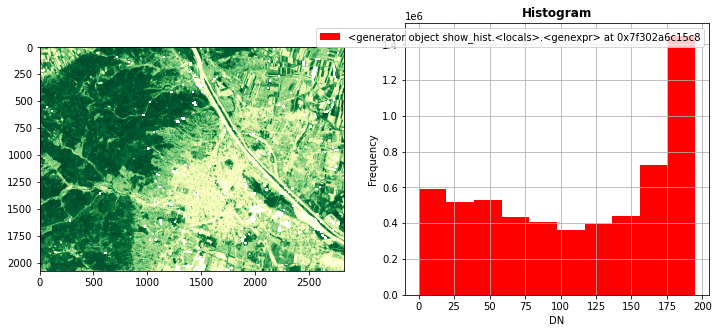

In [5]:
plot_result(geotiff_bytes)

## Retrieving results as timeseries

In [ ]:
import shapely
from openeo.rest.conversions import timeseries_json_to_pandas
import pandas as pd


polygon = shapely.geometry.Polygon([(3.71, 51.01), (3.72, 51.02), (3.73, 51.01)])
bbox = polygon.bounds

%time timeseries_dict = connection.load_collection("TERRASCOPE_S2_TOC_V2",\
                            temporal_extent = ["2020-01-01", "2020-12-10"],\
                            spatial_extent=dict(zip(["west", "south", "east", "north"], bbox)),\
                            bands=["TOC-B04_10M","TOC-B08_10M"])\
                            .ndvi()\
                            .polygonal_mean_timeseries(polygon)\
                            .execute()

dataframe = timeseries_json_to_pandas(timeseries_dict)
dataframe.index = pd.to_datetime(dataframe.index)
dataframe.dropna().plot(title='openEO NDVI with clouds')

CPU times: user 8.15 ms, sys: 1.02 ms, total: 9.17 ms
Wall time: 19.7 s


<AxesSubplot:title={'center':'openEO NDVI with clouds'}, xlabel='date'>